## Contexte du projet

Vous venez de rejoindre une ESN autant que développeur.se en IA pour renforcer l'équipe Data Science.

Votre première mission se déroule chez un client qui est en cours de digitaliser ses articles de journaux et souhaite établir une classification automatique de ces articles en 5 catégories: tech, business, sport, entertainment ou politics. Etant donné que le client souhaite participer à un concours d'innovation, il exige que la brique IA soit un réseau de neurones.

N'hésitez pas à reduire (pas trop) la taille du dataset si les opérations prennent trop de temps sur votre machine.


### 1. Import des librairies


In [6]:
import pandas as pd
import spacy
import numpy as np
import gensim.downloader
from sklearn_evaluation import plot

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models.word2vec import Word2Vec

### 2. Chargement des données

In [7]:
df = pd.read_csv('289df373-42e6-40fe-a3ab-8c8110f0a571.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [8]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [9]:
nlp = spacy.load('en_core_web_sm')

### 3. Nettoyage du texte
On enlève les mots les plus courants (stopwords) et les caractères non alphabétiques

In [10]:
def clean_docs(texts, remove_stopwords=False, n_process = 4):
    
    docs = nlp.pipe(texts, 
                    n_process=n_process,
                    disable=['parser', 'ner',
                             'lemmatizer', 'textcat'])
    stopwords = nlp.Defaults.stop_words

    docs_cleaned = []
    for doc in docs:
        tokens = [tok.text.lower().strip() for tok in doc if not tok.is_punct]
        if remove_stopwords:
            tokens = [tok for tok in tokens if tok not in stopwords]
        doc_clean = ' '.join(tokens)
        docs_cleaned.append(doc_clean)
        
    return docs_cleaned

In [11]:
df['text_clean'] = clean_docs(df['text'], remove_stopwords=True)
df.head()

,category,text,text_clean
0,tech,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems ...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books worldcom boss berni...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester rushed ...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership newc...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s raids box office ocean s crime caper ...


### 4. Encodage de la cible

In [12]:
le = LabelEncoder()
df['y'] = le.fit_transform(df['category'])
le.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text_clean'].values, 
                                                    df['y'].values, 
                                                    test_size=0.2, 
                                                    random_state=33,
                                                    stratify = df['y'].values)

In [14]:
# Prédiction sur le set d'entrainement
clf = LinearSVC(max_iter=10000, C=0.1)

In [15]:
def fit_vectorizers(vectorizer):
    pipeline = Pipeline(
    [
        ("vect", vectorizer()),
        ("scaling", StandardScaler(with_mean=False)),
        ("clf", clf),
    ]
    )

    parameters = {
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__stop_words": ("english", None)
    }

    grid_search = GridSearchCV(pipeline, parameters, scoring='f1_micro',
                               cv=4, n_jobs=4, verbose=1)
    grid_search.fit(X_train, y_train)

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print(f"CV scores {grid_search.cv_results_['mean_test_score']}")
    print(f"Mean F1 {np.mean(grid_search.cv_results_['mean_test_score'])}")
    
    return grid_search

In [16]:
cv_bow = fit_vectorizers(CountVectorizer)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


<AxesSubplot:title={'center':'Grid search results'}, xlabel='vect__stop_words', ylabel='Mean score'>

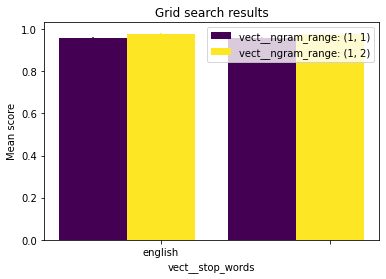

In [ ]:
# Un Barplot pour résumer les résultats de Gridsearch
plot.grid_search(cv_bow.cv_results_, change="vect__stop_words", kind='bar')

On obtient de bons scores supérieurs à 95%. Le meilleur score est obtenu en utilisant des stopwords et en analysant des bigrammes. D'après la représentation graphique l'influence de ces deux paramètres est assez marginale. La présence de Stopwords ne semble pas avoir d'effet alors que l'analyse avec des bigrammes apporte une légère amélioration.

In [ ]:
cv_tfidf = fit_vectorizers(TfidfVectorizer)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
	vect__ngram_range: (1, 2)
	vect__stop_words: 'english'
CV scores [0.96292135 0.96292135 0.9747191  0.9747191 ]
Mean F1 0.9688202247191011


Ici on a effectué une analyse par fréquence inverse des termes dans le document. Le score obtenu est bon mais pas fondamentalement meilleur qu'avec l'analyse par fréquence classique.

In [ ]:
X_train_tokens = [text.split() for text in X_train]
w2v_model = Word2Vec(X_train_tokens, vector_size=200, window=5, 
                     min_count=1, workers=4)

In [ ]:
def get_mean_vector(w2v_vectors, words):
    words = [word for word in words if word in w2v_vectors]
    if words:
        avg_vector = np.mean(w2v_vectors[words], axis=0)
    else:
        avg_vector = np.zeros_like(w2v_vectors['hi'])
    return avg_vector

def fit_w2v_avg(w2v_vectors):
    X_train_vectors = np.array([get_mean_vector(w2v_vectors, words)
                                for words in X_train_tokens])
    
    scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

    print(f"CV scores {scores}")
    print(f"Mean F1 {np.mean(scores)}")
    return scores

In [ ]:
cv_w2vec = fit_w2v_avg(w2v_model.wv)

CV scores [0.87191011 0.85842697 0.82696629 0.84494382]
Mean F1 0.850561797752809


In [ ]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')

In [ ]:
cv_w2vec_transfert = fit_w2v_avg(glove_model)

CV scores [0.97303371 0.96404494 0.97303371 0.96853933]
Mean F1 0.9696629213483146


In [ ]:
perfs = pd.DataFrame(
    [np.mean(cv_bow.cv_results_['mean_test_score']),
     np.mean(cv_tfidf.cv_results_['mean_test_score']),
    np.mean(cv_w2vec),
    np.mean(cv_w2vec_transfert)],
    index = ['Bag-of-Words','TF-IDF', 'Word2Vec non pré-entraîné', 'Word2Vec pré-entraîné'],
    columns = ["Mean F1 score"]
).sort_values("Mean F1 score",ascending = False)
perfs

,Mean F1 score
Word2Vec pré-entraîné,0.969663
TF-IDF,0.968820
Bag-of-Words,0.966994
Word2Vec non pré-entraîné,0.850562


Les meilleures méthodes tournent toutes les trois autour de 96.5% de performance. 